### Predicting ratings

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools
import torch
torch.use_deterministic_algorithms(True)

In [2]:
data = pd.read_csv("../dat/data_clean.csv")

C:\Users\Balint\miniconda3\envs\d2l\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273543 entries, 0 to 273542
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tconst                       273543 non-null  object 
 1   titleType                    273543 non-null  object 
 2   primaryTitle                 273543 non-null  object 
 3   originalTitle                273543 non-null  object 
 4   isAdult                      273543 non-null  int64  
 5   startYear                    273543 non-null  object 
 6   endYear                      273543 non-null  object 
 7   runtimeMinutes               273543 non-null  object 
 8   genres                       273543 non-null  object 
 9   averageRating                273543 non-null  float64
 10  numVotes                     273543 non-null  int64  
 11  Budget                       49881 non-null   float64
 12  Gross US & Canada            18982 non-null   float64
 13 

In [4]:
data["Critic reviews"] = data["Critic reviews"].fillna(0)
data["User reviews"] = data["User reviews"].fillna(0)

data["isAdult2"] = data.apply(lambda row: int("Adult" in row["genres"]), axis=1)
print(len(data[data["isAdult"] != data["isAdult2"]]))  # We use the one based on the genres

# tconst was only required for joins
# titleType is only films for us, we filtered them
# we do not use the titles as predictors
# endYear is None for all films
# isAdult will be added back in a consistent format later on

# We drop writers and directors. These are interesting features,
# but having them as binary columns would be infeasible.
data = data.drop(columns=[
    "tconst", "titleType", "primaryTitle", "originalTitle", "endYear",
    "isAdult", "isAdult2", "Gross US & Canada", "Opening weekend US & Canada",
    "writers", "directors"])
data = data.dropna()

318


In [5]:
genre_list = data["genres"].unique().tolist()
for i, entry in enumerate(genre_list):
    genre_list[i] = entry.split(",")

genre_set = set(itertools.chain(*genre_list))
print(genre_set)

{'Romance', 'Animation', 'Fantasy', 'Drama', 'Documentary', 'Sci-Fi', 'Family', 'Horror', 'News', 'Western', 'Crime', 'Mystery', 'Musical', 'Biography', 'Adventure', 'Comedy', 'Film-Noir', 'Action', 'Music', 'War', 'Sport', 'History', 'Thriller'}


In [6]:
# News - History - Biography - Documentary --> Documentary
# Film-Noir - Crime --> Crime
# Western - Action --> Action
genre_set.difference_update(["News", "History", "Biography", "Film-Noir", "Western"])
transformation_dict = {
    "Documentary":  ["News", "History", "Biography", "Documentary"],
    "Crime": ["Film-Noir", "Crime"],
    "Action": ["Western", "Action"]
}
for genre in genre_set:
    print(genre, end=" ")
    if genre not in transformation_dict:
        transformation_dict[genre] = [genre]
    data[f"is{genre}"] = data.apply(lambda row: int(any(g in row["genres"] for g in transformation_dict[genre])), axis=1)

Romance Animation Fantasy Drama Documentary Sci-Fi Family Horror Crime Mystery Musical Adventure Comedy Action Music War Sport Thriller 

In [7]:
results = []
for genre in genre_set:
    results.append(data[f"is{genre}"].sum())

sum_results = sum(results)
for genre in genre_set:
    print(genre, data[f"is{genre}"].sum() / sum_results * 100, "% - ", data[f"is{genre}"].sum())

Romance 6.737305837226083 % -  1774
Animation 1.993847556112567 % -  525
Fantasy 2.8179712126390943 % -  742
Drama 21.920929702631877 % -  5772
Documentary 4.564961452280582 % -  1202
Sci-Fi 2.529338042611371 % -  666
Family 2.2938741407466483 % -  604
Horror 4.348486574759789 % -  1145
Crime 7.569025103490183 % -  1993
Mystery 3.4901826744141884 % -  919
Musical 0.5089058524173028 % -  134
Adventure 6.7107212031445815 % -  1767
Comedy 14.488625574417988 % -  3815
Action 9.843910219892901 % -  2592
Music 1.7659792639854164 % -  465
War 0.8658995100831719 % -  228
Sport 0.9190687782461737 % -  242
Thriller 6.63096730090008 % -  1746


In [8]:
# Genres are added as binary predictors, thus the genres column is no longer used.
data = data.drop(columns=["genres"])  # "isMusical", "isFilm-Noir", "isNews", "isSport", "genres"])

def unrated_to_not_rated(row):
    if row["Rating"] == "Unrated":
        return "Not Rated"
    else:
        return row["Rating"]

data["Rating"] = data.apply(unrated_to_not_rated, axis=1)

In [9]:
data[f"isRated"] = data.apply(lambda row: int(row["Rating"] != "Not Rated"), axis=1)

In [10]:
data = data.drop(columns=["Rating"])

In [11]:
def clean_unknowns(row, column):
    if row[column] == "\\N":
        return None
    else:
        return row[column]

def clean_reviews(row, column):
    if isinstance(row[column], str) and "K" in row[column]:
        if "." in row[column]:
            return int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100
        else:
            return int(row[column][:-1]) * 1000
    else:
        return row[column]

data["startYear"] = data.apply(lambda row: clean_unknowns(row, "startYear"), axis=1)
data["runtimeMinutes"] = data.apply(lambda row: clean_unknowns(row, "runtimeMinutes"), axis=1)
data["User reviews"] = data.apply(lambda row: clean_reviews(row, "User reviews"), axis=1)
data["Critic reviews"] = data.apply(lambda row: clean_reviews(row, "Critic reviews"), axis=1)

for column in ["startYear", "runtimeMinutes", "User reviews", "Critic reviews"]:
    data[column] = pd.to_numeric(data[column])



In [12]:
print("All features present:")
filtered = data.dropna()
print(len(filtered))

All features present:
10714


In [13]:
filtered.corr().style.background_gradient(cmap='coolwarm')

,startYear,runtimeMinutes,averageRating,numVotes,Budget,Gross worldwide,Critic reviews,User reviews,isRomance,isAnimation,isFantasy,isDrama,isDocumentary,isSci-Fi,isFamily,isHorror,isCrime,isMystery,isMusical,isAdventure,isComedy,isAction,isMusic,isWar,isSport,isThriller,isRated
startYear,1.000000,-0.035866,-0.201522,0.000240,-0.023247,-0.057779,0.193535,0.059286,-0.072984,0.061377,-0.007435,-0.023440,0.076020,-0.021172,-0.006475,0.010315,-0.043072,-0.012530,-0.079189,0.014030,-0.029636,0.062450,-0.049175,-0.055095,-0.001944,0.037106,-0.166430
runtimeMinutes,-0.035866,1.000000,0.327356,0.263119,0.281783,0.222601,0.197618,0.263035,0.037874,-0.188850,-0.007126,0.251510,0.132065,0.013944,-0.076188,-0.161497,0.034734,-0.004244,0.066672,0.023855,-0.198908,0.157000,0.042845,0.098452,0.023717,-0.017890,-0.059407
averageRating,-0.201522,0.327356,1.000000,0.373765,0.094344,0.207771,0.320645,0.259345,0.017810,0.016830,-0.050636,0.259717,0.203175,-0.039149,-0.063889,-0.194478,0.033494,-0.005072,0.017918,-0.027122,-0.116203,-0.088066,0.039827,0.073410,0.030757,-0.086492,0.009748
numVotes,0.000240,0.263119,0.373765,1.000000,0.484440,0.604826,0.632424,0.748153,-0.062362,0.032153,0.057248,-0.053881,-0.039296,0.161098,-0.019788,-0.030451,0.012083,0.026221,-0.020421,0.174233,-0.058298,0.143913,-0.039960,-0.003589,-0.020418,0.008170,0.181424
Budget,-0.023247,0.281783,0.094344,0.484440,1.000000,0.618972,0.470934,0.493993,-0.074949,0.156256,0.122698,-0.180196,-0.066076,0.187617,0.073103,-0.114956,-0.030025,-0.035106,-0.002538,0.412964,0.001382,0.288313,-0.046011,-0.018468,-0.014845,-0.024849,0.265037
Gross worldwide,-0.057779,0.222601,0.207771,0.604826,0.618972,1.000000,0.447165,0.528583,-0.046415,0.150514,0.085165,-0.143340,-0.054449,0.120041,0.059786,-0.056392,-0.057878,-0.029502,-0.004438,0.302571,0.004148,0.157823,-0.024488,-0.022194,-0.023446,-0.022244,0.165175
Critic reviews,0.193535,0.197618,0.320645,0.632424,0.470934,0.447165,1.000000,0.635358,-0.080864,0.020177,0.089842,-0.038121,-0.017815,0.187049,-0.051485,0.107734,-0.004029,0.084005,-0.023878,0.174983,-0.093213,0.153225,-0.044073,-0.024894,-0.043205,0.045821,0.252920
User reviews,0.059286,0.263035,0.259345,0.748153,0.493993,0.528583,0.635358,1.000000,-0.071699,-0.015183,0.084869,-0.054181,-0.051012,0.187933,-0.031068,0.052397,-0.015094,0.054678,-0.001391,0.178414,-0.102268,0.168931,-0.027985,-0.005661,-0.031435,0.029438,0.181563
isRomance,-0.072984,0.037874,0.017810,-0.062362,-0.074949,-0.046415,-0.080864,-0.071699,1.000000,-0.099953,-0.050301,0.140260,-0.096292,-0.078285,-0.080574,-0.137023,-0.156808,-0.084438,0.042507,-0.164133,0.150672,-0.210017,0.029585,-0.004788,-0.025468,-0.158329,0.008371
isAnimation,0.061377,-0.188850,0.016830,0.032153,0.156256,0.150514,0.020177,-0.015183,-0.099953,1.000000,-0.012532,-0.189761,-0.071102,-0.042324,0.105734,-0.077121,-0.101847,-0.064898,-0.013874,0.379128,0.103894,-0.038377,-0.039862,-0.030476,-0.034507,-0.098919,0.041446


In [14]:
np.random.seed(42)
test_indices = np.random.choice(len(filtered), replace=False, size=int(len(filtered) / 10))


test_set = filtered.iloc[test_indices]
test_set, test_targets = test_set.drop("averageRating", axis=1).to_numpy(), test_set["averageRating"].to_numpy()
train_set = filtered.iloc[~test_indices]
train_set, train_targets = train_set.drop("averageRating", axis=1).to_numpy(), train_set["averageRating"].to_numpy()

In [15]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10714 entries, 1031 to 273540
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   startYear        10714 non-null  int64  
 1   runtimeMinutes   10714 non-null  float64
 2   averageRating    10714 non-null  float64
 3   numVotes         10714 non-null  int64  
 4   Budget           10714 non-null  float64
 5   Gross worldwide  10714 non-null  float64
 6   Critic reviews   10714 non-null  float64
 7   User reviews     10714 non-null  float64
 8   isRomance        10714 non-null  int64  
 9   isAnimation      10714 non-null  int64  
 10  isFantasy        10714 non-null  int64  
 11  isDrama          10714 non-null  int64  
 12  isDocumentary    10714 non-null  int64  
 13  isSci-Fi         10714 non-null  int64  
 14  isFamily         10714 non-null  int64  
 15  isHorror         10714 non-null  int64  
 16  isCrime          10714 non-null  int64  
 17  isMyster

### Logistic Regression, MAE

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

test_set = torch.from_numpy(test_set)
test_set_normalized = (test_set - test_set.mean(dim=0, keepdims=True)) / test_set.std(dim=0, keepdims=True)
test_set_normalized = torch.nan_to_num(test_set_normalized, nan=0)
test_targets = torch.from_numpy(test_targets)

train_set = torch.from_numpy(train_set)
train_set_normalized = (train_set - train_set.mean(dim=0, keepdims=True)) / train_set.std(dim=0, keepdims=True)
train_set_normalized = torch.nan_to_num(train_set_normalized, nan=0)
train_targets = torch.from_numpy(train_targets)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x)) * 9 + 1

In [17]:


# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

torch.manual_seed(1337)
model = Model()

opt = torch.optim.SGD(model.parameters(), lr=0.001)

best_loss = np.inf
best_pred_lr = None


epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_pred_lr = pred
            
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.0890], dtype=torch.float64)
Epoch 100, Training Loss (MAE) 1.2904, Validation Loss (MAE) 1.3194

tensor([0.0740], dtype=torch.float64)
Epoch 200, Training Loss (MAE) 1.0708, Validation Loss (MAE) 1.0960

tensor([0.0520], dtype=torch.float64)
Epoch 300, Training Loss (MAE) 0.8997, Validation Loss (MAE) 0.9292

tensor([0.0356], dtype=torch.float64)
Epoch 400, Training Loss (MAE) 0.7827, Validation Loss (MAE) 0.8123

tensor([0.0239], dtype=torch.float64)
Epoch 500, Training Loss (MAE) 0.7047, Validation Loss (MAE) 0.7334

tensor([0.0129], dtype=torch.float64)
Epoch 600, Training Loss (MAE) 0.6577, Validation Loss (MAE) 0.6844

tensor([0.0083], dtype=torch.float64)
Epoch 700, Training Loss (MAE) 0.6288, Validation Loss (MAE) 0.6557

tensor([0.0053], dtype=torch.float64)
Epoch 800, Training Loss (MAE) 0.6104, Validation Loss (MAE) 0.6386

tensor([0.0032], dtype=torch.float64)
Epoch 900, Training Loss (MAE) 0.5995, Validation Loss (MAE) 0.6277

tensor([0.0019], dtype=torch.float64)

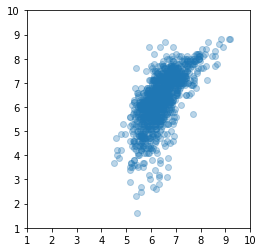

In [18]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Logistic Regression, MSE

In [19]:

loss_fn = nn.MSELoss()
val_loss_fn = nn.L1Loss()
torch.manual_seed(1337)


model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

best_loss = np.inf
epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MSE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.2992], dtype=torch.float64)
Epoch 100, Training Loss (MSE) 1.1428, Validation Loss (MAE) 0.8856

tensor([0.0562], dtype=torch.float64)
Epoch 200, Training Loss (MSE) 0.7685, Validation Loss (MAE) 0.7050

tensor([0.0158], dtype=torch.float64)
Epoch 300, Training Loss (MSE) 0.6860, Validation Loss (MAE) 0.6523

tensor([0.0062], dtype=torch.float64)
Epoch 400, Training Loss (MSE) 0.6591, Validation Loss (MAE) 0.6321

tensor([0.0030], dtype=torch.float64)
Epoch 500, Training Loss (MSE) 0.6475, Validation Loss (MAE) 0.6229

tensor([0.0016], dtype=torch.float64)
Epoch 600, Training Loss (MSE) 0.6416, Validation Loss (MAE) 0.6183

tensor([0.0009], dtype=torch.float64)
Epoch 700, Training Loss (MSE) 0.6383, Validation Loss (MAE) 0.6159

tensor([0.0006], dtype=torch.float64)
Epoch 800, Training Loss (MSE) 0.6364, Validation Loss (MAE) 0.6146

tensor([0.0003], dtype=torch.float64)
Epoch 900, Training Loss (MSE) 0.6352, Validation Loss (MAE) 0.6139

tensor([0.0002], dtype=torch.float64)

### Logistic Regression, BCE

In [20]:

test_targets_bce = (test_targets - 1) / 9
train_targets_bce = (train_targets - 1) / 9

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x))

loss_fn = nn.BCELoss()
val_loss_fn = nn.L1Loss()

best_loss = np.inf

torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets_bce)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (BCE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.0015], dtype=torch.float64)
Epoch 100, Training Loss (BCE) 0.7377, Validation Loss (MAE) 1.5452

tensor([0.0014], dtype=torch.float64)
Epoch 200, Training Loss (BCE) 0.7339, Validation Loss (MAE) 1.5139

tensor([0.0013], dtype=torch.float64)
Epoch 300, Training Loss (BCE) 0.7303, Validation Loss (MAE) 1.4838

tensor([0.0012], dtype=torch.float64)
Epoch 400, Training Loss (BCE) 0.7269, Validation Loss (MAE) 1.4545

tensor([0.0011], dtype=torch.float64)
Epoch 500, Training Loss (BCE) 0.7237, Validation Loss (MAE) 1.4261

tensor([0.0011], dtype=torch.float64)
Epoch 600, Training Loss (BCE) 0.7207, Validation Loss (MAE) 1.3987

tensor([0.0010], dtype=torch.float64)
Epoch 700, Training Loss (BCE) 0.7179, Validation Loss (MAE) 1.3721

tensor([0.0010], dtype=torch.float64)
Epoch 800, Training Loss (BCE) 0.7153, Validation Loss (MAE) 1.3463

tensor([0.0009], dtype=torch.float64)
Epoch 900, Training Loss (BCE) 0.7128, Validation Loss (MAE) 1.3214

tensor([0.0008], dtype=torch.float64)

### ReLU network #2, MAE

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1

model = Model()
list(model.modules())[1:]

[Linear(in_features=26, out_features=32, bias=True),
 Linear(in_features=32, out_features=1, bias=True)]

In [22]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1


loss_fn = nn.L1Loss()
torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1
best_loss = np.inf
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.7760, Validation Loss (MAE) 0.7995

Epoch 200, Training Loss (MAE) 0.6991, Validation Loss (MAE) 0.7255

Epoch 300, Training Loss (MAE) 0.6621, Validation Loss (MAE) 0.6909

Epoch 400, Training Loss (MAE) 0.6376, Validation Loss (MAE) 0.6706

Epoch 500, Training Loss (MAE) 0.6206, Validation Loss (MAE) 0.6568

Epoch 600, Training Loss (MAE) 0.6087, Validation Loss (MAE) 0.6487

Epoch 700, Training Loss (MAE) 0.6000, Validation Loss (MAE) 0.6435

Epoch 800, Training Loss (MAE) 0.5933, Validation Loss (MAE) 0.6395

Epoch 900, Training Loss (MAE) 0.5877, Validation Loss (MAE) 0.6361

Epoch 1000, Training Loss (MAE) 0.5826, Validation Loss (MAE) 0.6333

Epoch 1100, Training Loss (MAE) 0.5782, Validation Loss (MAE) 0.6310

Epoch 1200, Training Loss (MAE) 0.5741, Validation Loss (MAE) 0.6288

Epoch 1300, Training Loss (MAE) 0.5704, Validation Loss (MAE) 0.6270

Epoch 1400, Training Loss (MAE) 0.5668, Validation Loss (MAE) 0.6252

Epoch 1500, Training Loss (MA

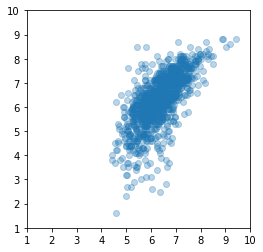

In [23]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### ReLU network #4, MAE

In [24]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_dim = 32
        
        self.layer1 = nn.Linear(26, self.hidden_dim, dtype=torch.double)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer4 = nn.Linear(self.hidden_dim, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
    
        return torch.sigmoid(self.layer4(x)) * 9 + 1


loss_fn = nn.L1Loss()
best_loss = np.inf


torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1

for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8335, Validation Loss (MAE) 0.8610

Epoch 200, Training Loss (MAE) 0.8217, Validation Loss (MAE) 0.8498

Epoch 300, Training Loss (MAE) 0.8139, Validation Loss (MAE) 0.8422

Epoch 400, Training Loss (MAE) 0.8054, Validation Loss (MAE) 0.8339

Epoch 500, Training Loss (MAE) 0.7949, Validation Loss (MAE) 0.8241

Epoch 600, Training Loss (MAE) 0.7822, Validation Loss (MAE) 0.8122

Epoch 700, Training Loss (MAE) 0.7672, Validation Loss (MAE) 0.7977

Epoch 800, Training Loss (MAE) 0.7505, Validation Loss (MAE) 0.7812

Epoch 900, Training Loss (MAE) 0.7330, Validation Loss (MAE) 0.7642

Epoch 1000, Training Loss (MAE) 0.7139, Validation Loss (MAE) 0.7455

Epoch 1100, Training Loss (MAE) 0.6938, Validation Loss (MAE) 0.7277

Epoch 1200, Training Loss (MAE) 0.6760, Validation Loss (MAE) 0.7110

Epoch 1300, Training Loss (MAE) 0.6609, Validation Loss (MAE) 0.6962

Epoch 1400, Training Loss (MAE) 0.6465, Validation Loss (MAE) 0.6836

Epoch 1500, Training Loss (MA

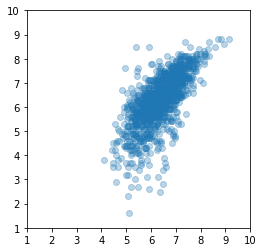

In [25]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

In [26]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_dim = 32
        
        self.layer1 = nn.Linear(26, self.hidden_dim, dtype=torch.double)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer4 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer5 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer6 = nn.Linear(self.hidden_dim, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
    
        return torch.sigmoid(self.layer6(x)) * 9 + 1

loss_fn = nn.L1Loss()
torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-2)

epoch = 0
grad_norm = 1
pred = None 
best_loss = np.inf


for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_pred_relu = pred
            
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8278, Validation Loss (MAE) 0.8548

Epoch 200, Training Loss (MAE) 0.8258, Validation Loss (MAE) 0.8527

Epoch 300, Training Loss (MAE) 0.8236, Validation Loss (MAE) 0.8505

Epoch 400, Training Loss (MAE) 0.8207, Validation Loss (MAE) 0.8476

Epoch 500, Training Loss (MAE) 0.8163, Validation Loss (MAE) 0.8432

Epoch 600, Training Loss (MAE) 0.8092, Validation Loss (MAE) 0.8361

Epoch 700, Training Loss (MAE) 0.7959, Validation Loss (MAE) 0.8226

Epoch 800, Training Loss (MAE) 0.7664, Validation Loss (MAE) 0.7938

Epoch 900, Training Loss (MAE) 0.7093, Validation Loss (MAE) 0.7363

Epoch 1000, Training Loss (MAE) 0.6420, Validation Loss (MAE) 0.6753

Epoch 1100, Training Loss (MAE) 0.6084, Validation Loss (MAE) 0.6465

Epoch 1200, Training Loss (MAE) 0.5880, Validation Loss (MAE) 0.6322

Epoch 1300, Training Loss (MAE) 0.5733, Validation Loss (MAE) 0.6211

Epoch 1400, Training Loss (MAE) 0.5614, Validation Loss (MAE) 0.6123

Epoch 1500, Training Loss (MA

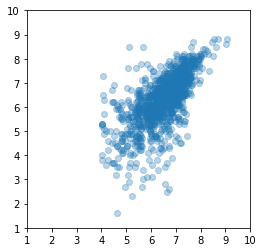

In [27]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Linear Regression, Transformed Outputs

In [28]:
filtered[filtered["averageRating"] <= 1.3]  # we can use inverse formula
test_targets_inv = -torch.log(9 / (test_targets - 1) - 1)
train_targets_inv = -torch.log(9 / (train_targets - 1) - 1)
train_targets_inv.min(), train_targets_inv.max()

(tensor(-2.1972, dtype=torch.float64), tensor(1.8718, dtype=torch.float64))

In [29]:
opt_weights = torch.linalg.pinv(train_set) @ train_targets_inv
transformed_preds = test_set @ opt_weights
preds = 9 * 1 / (1 + torch.exp(-transformed_preds)) + 1
((test_targets - preds)**2).mean()

tensor(0.7431, dtype=torch.float64)

### Save the data for plot

In [30]:
x1 = best_pred_lr.squeeze().numpy()
x2 = best_pred_relu.squeeze().numpy()
y = test_targets.squeeze().numpy()

# np.save("../dat/data_fig1/pred_lr.npy", x1)
# np.save("../dat/data_fig1/pred_relu.npy", x2)
# np.save("../dat/data_fig1/true_ratings.npy", y)